In [2]:
%load_ext autoreload
%autoreload 2

import sklearn.metrics as metrics
from utils.temperature_scaling import ModelWithTemperature
from matplotlib import pyplot as plt
import utils.visualisations
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms



import utils.metrics
import utils.model

import models.unet_model
from datasets.covid19dataset import Covid19Dataset


In [3]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("cpu")
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [38]:
transform = torchvision.transforms.Compose([
    # torchvision.transforms.Resize(256),
    # torchvision.transforms.CenterCrop(224),
])

target_transform = torchvision.transforms.Compose([
    # torchvision.transforms.Resize(256),
    # torchvision.transforms.CenterCrop(224),
])

data = Covid19Dataset("covid19", multi=True, transform=transform,
                      target_transform=target_transform)


data_train, data_val, data_test = torch.utils.data.random_split(
    data, [60, 10, 30], generator=torch.Generator().manual_seed(0))

data_loader_train = torch.utils.data.DataLoader(data_train,
                                                batch_size=16,
                                                shuffle=True)

data_loader_val = torch.utils.data.DataLoader(data_val,
                                               batch_size=10,
                                               shuffle=False)

data_loader_test = torch.utils.data.DataLoader(data_test,
                                               batch_size=10,
                                               shuffle=False)

dataset_sizes = {"train": len(data_train), "val": len(data_test)}
data_loaders = {"train": data_loader_train, "val": data_loader_test}

In [5]:
model = torch.load("checkpoints/unet_covid19.pt")
model_dropout = torch.load("checkpoints/unet_dropout_covid19.pt")
# model = torch.load("checkpoints/VOC_segmentation_deeplabv3_mobilenet_v3_large.pt")
# model = torch.load("checkpoints/unet_unewighted.pt")

from torchensemble import VotingClassifier
model_ensemble = VotingClassifier(model, 5)
for i in range(5):
    model_ensemble.estimators_.append(torch.load(f"checkpoints/unet_covid19-{i}.pt"))


In [7]:
model_dropout

UNet_Dropout(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Sequential(
        (0): ReLU()
        (1): Dropout2d(p=0.1, inplace=False)
      )
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Sequential(
        (0): ReLU()
        (1): Dropout2d(p=0.1, inplace=False)
      )
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [8]:
from utils.temperature_scaling import ModelWithTemperature
scaled_model = ModelWithTemperature(model, device)
# scaled_model.temperature = torch.nn.Parameter(torch.tensor(1.458))
scaled_model.set_temperature(data_loader_val)

Before temperature - NLL: 0.146, ECE: 0.014
Optimal temperature: 1.085
After temperature - NLL: 0.149, ECE: 0.020


ModelWithTemperature(
  (model): UNet(
    (inc): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(128

In [40]:
from tqdm import tqdm
import torchmetrics  
from typing import OrderedDict
import torch.nn.functional as F




def run_validation(model, data_loader, test_progress: utils.metrics.Progress, device, mc_dropout_iters=0):
    softmax = nn.Softmax(dim=1)
    progress_bar = tqdm(data_loader)
    count = 0
    running_corrects = 0
    model = model.to(device)
    softmax = torch.nn.Softmax(dim=1)
    for inputs, labels in progress_bar:
        # labels = (labels * 255).squeeze().to(torch.uint8)
        # labels[labels == 255] = 21
        inputs = inputs.to(device)
        count += labels.numel()
        model.eval()
        with torch.no_grad():
            logits = model(inputs)
        if isinstance(logits, OrderedDict):
            logits = logits["out"]    
        logits = logits.cpu()
        probs = softmax(logits)
        max_probs, preds = torch.max(probs, 1)
        # print(iou(preds, labels))
        # return
        running_corrects += np.count_nonzero(preds == labels.squeeze(1))
        # print(torchmetrics.functional.iou(
        # preds, labels, ignore_index=21, num_classes=22))
        if mc_dropout_iters > 0:
            mc_means, mc_vars = utils.mc_dropout.mc_dropout(
                model, inputs, logits.shape[1:], T=mc_dropout_iters)
            # batch_nll = - utils.mc_dropout.compute_log_likelihood(
            #     mc_means, torch.nn.functional.one_hot(labels, num_classes=mc_means.shape[-1]), torch.sqrt(mc_vars))
            batch_nll = torch.tensor([0])
            mc_predictions = mc_means.argmax(axis=1)
            test_progress.dropout_outputs.append(mc_means.numpy())
            test_progress.dropout_predictions = np.append(
                test_progress.dropout_predictions, mc_predictions)
            test_progress.dropout_variances = np.append(
                test_progress.dropout_variances, mc_vars)

        test_progress.update(preds, labels, probs, logits)
        progress_bar.set_description(
            f"Avg. acc.: {100*running_corrects/count:.2f}")

    test_progress.predictions = np.concatenate(test_progress.predictions)
    test_progress.logits = np.concatenate(test_progress.logits)
    test_progress.probs = np.concatenate(test_progress.probs)
    if mc_dropout_iters > 0:
        test_progress.dropout_outputs = np.concatenate(
            test_progress.dropout_outputs)
    return test_progress

progress_ensemble = run_validation(
    model_ensemble, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=0)

progress = run_validation(
    model, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=0)

progress_dropout = run_validation(
    model_dropout, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=20)

progress_scaled = run_validation(
    scaled_model, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=0)    

Avg. acc.: 95.73: 100%|██████████| 3/3 [00:00<00:00,  8.12it/s]


In [29]:
np.moveaxis(progress.probs,1,-1).reshape(-1,4)

array([[0.97199667, 0.98816407, 0.9880679 , 0.9879985 ],
       [0.9881634 , 0.9881887 , 0.988208  , 0.9882107 ],
       [0.9882131 , 0.98821414, 0.9882158 , 0.98821765],
       ...,
       [0.00359839, 0.0035995 , 0.00360063, 0.00360122],
       [0.00360036, 0.00359734, 0.00360113, 0.00363275],
       [0.00369007, 0.00362168, 0.0030571 , 0.00717922]], dtype=float32)

In [41]:


preds = torch.as_tensor(progress.predictions).to(torch.long)

# preds_mcd = torch.Tensor(progress.dropout_predictions.reshape(progress.predictions.shape)).to(torch.uint8)


labels = torch.as_tensor(progress.labels.reshape(progress.predictions.shape)).to(torch.long)

print(utils.metrics.iou(preds, labels, num_classes=4))
print(utils.metrics.mean_class_iou(preds, labels, num_classes=4))

# torchmetrics.functional.jaccard_index(preds[:32], labels[:32],absent_score=torch.nan, reduction="none").nanmean(), torchmetrics.functional.jaccard_index(preds[32:64], labels[32:64], absent_score=torch.nan, reduction="none").nanmean(), torchmetrics.functional.jaccard_index(preds[:64], labels[:64], absent_score=torch.nan, reduction="none").nanmean()


tensor(0.4492)
tensor(0.4893)


In [47]:
progress.max_probs[idx]

0.9879984855651855

In [56]:
labels[idx]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

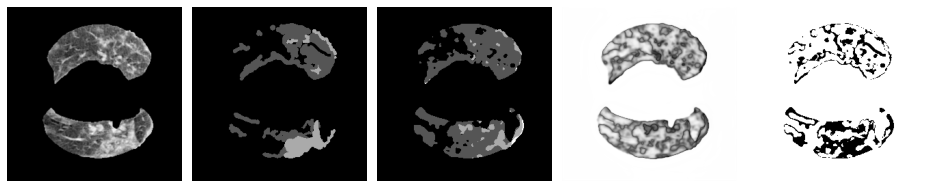

In [68]:
idx = 3
fig, axs = plt.subplots(1, 5, figsize=(13,8))
axs[0].imshow(data_test[idx][0].squeeze(0), cmap="gray")
axs[0].axis("off")
axs[1].imshow(labels[idx], cmap="gray", vmax=3)
axs[1].axis("off")
axs[2].imshow(progress_ensemble.predictions[idx], cmap="gray", vmax=3)
axs[2].axis("off")
axs[3].imshow(progress_ensemble.logits.max(axis=1)[idx], cmap="gray")
axs[3].axis("off")

axs[4].imshow(progress_ensemble.predictions[idx] == labels[idx].numpy(), cmap="gray")
axs[4].axis("off")
plt.tight_layout()

plt.savefig("figures/covid19-examples-ensemble.pdf")




In [24]:
progress_ensemble.predictions.shape

(30, 256, 256)

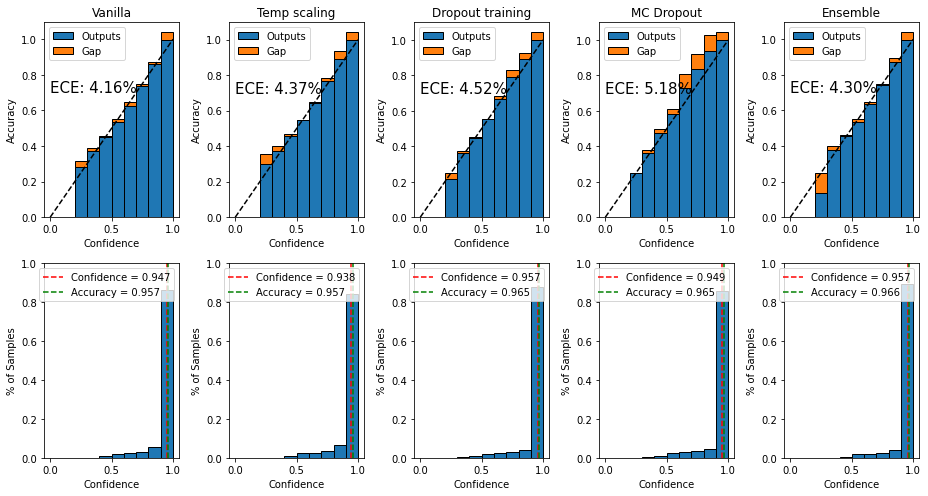

In [13]:
# nll = nn.CrossEntropyLoss()(torch.tensor(progress.logits), torch.tensor(
#     progress.labels, dtype=torch.long)).item()
# print(
#     f"Accuracy: {(progress.predictions==progress.labels).sum()*100/len(progress.labels):.2f}%, "
#     f"NLL: {nll:4f}"
# )

# # mc_logits = progress.dropout_logits.mean(axis=0)
# dropout_max_probs = progress.dropout_outputs.max(axis=-1)

# utils.visualisations.samples_removed_vs_acc([
#     ("Max prob", np.argsort(progress.max_probs)),
#     ("Dropout max probs", np.argsort(dropout_max_probs))],
#     progress.labels,
#     progress.predictions,
#     progress.dropout_predictions)

dropout_max_probs = progress_dropout.dropout_outputs.max(axis=1).ravel()
ensemble_max_probs = progress_ensemble.logits.max(axis=1).ravel()

utils.visualisations.calibration_graph([
        ("Vanilla", progress.max_probs, np.argsort(progress.max_probs), progress.predictions.ravel()),
        ("Temp scaling", progress_scaled.max_probs, np.argsort(progress_scaled.max_probs), progress_scaled.predictions.ravel()),
        ("Dropout training", progress_dropout.max_probs, np.argsort(progress_dropout.max_probs), progress_dropout.predictions.ravel()),
        ("MC Dropout", dropout_max_probs, np.argsort(dropout_max_probs), progress_dropout.dropout_outputs.argmax(axis=1).ravel()),
        ("Ensemble", ensemble_max_probs, np.argsort(ensemble_max_probs), progress_ensemble.predictions.ravel()),


    ],
    progress.labels,
    figsize=(13,7)
    )

plt.savefig("figures/covid19-calibration.pdf")

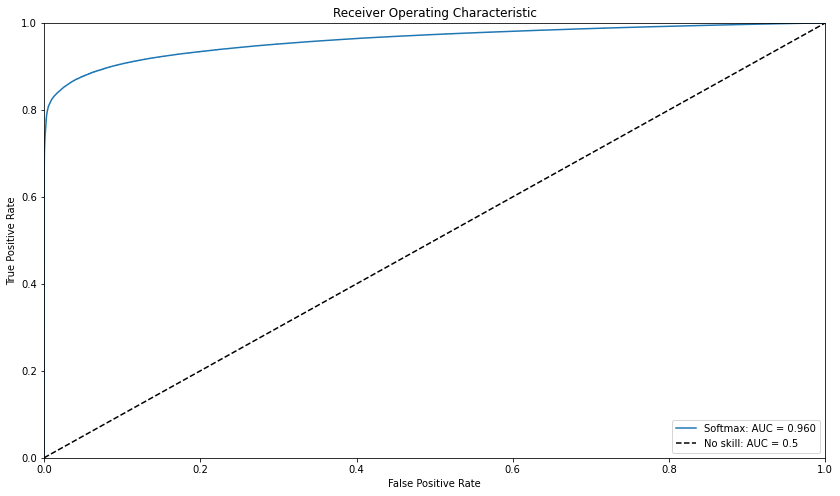

In [10]:
curves = []

correct = progress.predictions.ravel() == progress.labels.ravel()
fpr, tpr, _ = metrics.roc_curve(correct, progress.max_probs)
roc_auc = metrics.auc(fpr, tpr)

prec, recall, _ = metrics.precision_recall_curve(correct, progress.max_probs)
aupr = metrics.auc(recall, prec)
curves.append({
    "fpr": fpr,
    "tpr": tpr,
    "auroc": roc_auc,
    "prec": prec,
    "recall": recall,
    "aupr": aupr,
    "label": "Softmax"
})

# correct = progress.dropout_predictions == progress.labels
# dropout_max_probs = progress.dropout_outputs.max(axis=-1)
# fpr, tpr, _ = metrics.roc_curve(correct, dropout_max_probs)
# roc_auc = metrics.auc(fpr, tpr)

# prec, recall, _ = metrics.precision_recall_curve(correct, dropout_max_probs)
# aupr = metrics.auc(recall, prec)

# curves.append({
#     "fpr": fpr,
#     "tpr": tpr,
#     "auroc": roc_auc,
#     "prec": prec,
#     "recall": recall,
#     "aupr": aupr,
#     "label": "MC Dropout"
# })


plt.figure(figsize=(14, 8))
plt.title('Receiver Operating Characteristic')
for curve in curves:
    plt.plot(curve["fpr"], curve["tpr"],
             label=f"{curve['label']}: AUC = {curve['auroc']:.3f}")
plt.plot([0, 1], [0, 1], 'k--', label=f"No skill: AUC = 0.5")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

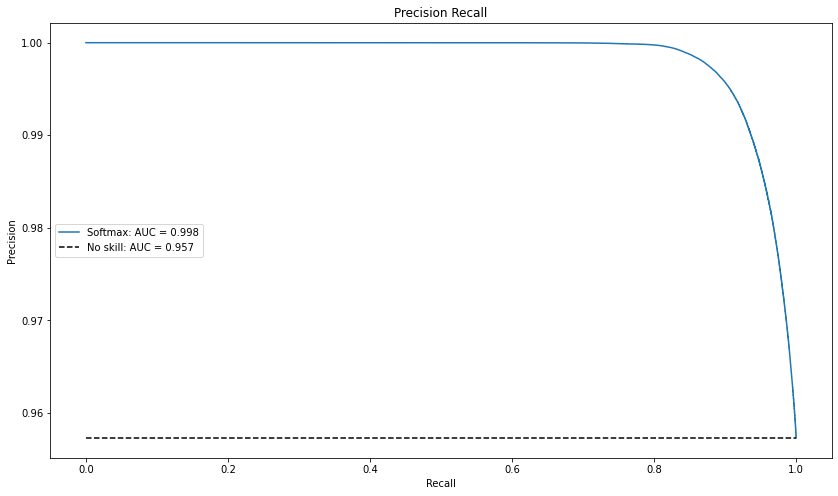

In [11]:
no_skill = correct.sum() / len(correct)
plt.figure(figsize=(14, 8))
plt.title('Precision Recall')
for curve in curves:
    plt.plot(curve["recall"], curve["prec"],
             label=f"{curve['label']}: AUC = {curve['aupr']:.3f}")
# axis labels
plt.plot([0, 1], [no_skill, no_skill], color="k",
         linestyle='--', label=f'No skill: AUC = {no_skill:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [46]:
progress_model_dropout.dropout_predictions.shape

(1966080,)

In [15]:
curves = {
    "Vanilla": utils.metrics.model_metrics(),
    "Temperature scaling":utils.metrics.model_metrics(),
    "Dropout training": utils.metrics.model_metrics(),
    "MC Dropout":utils.metrics.model_metrics(),
    "Ensemble": utils.metrics.model_metrics(),
}

from datasets.transforms import AddGaussianNoise


for s in np.arange(0, 0.6, 0.05):
    transforms_test = torchvision.transforms.Compose(
        [
            # transforms.RandomRotation(degrees=(s,s)),
            # transforms.ColorJitter(brightness=s/2, saturation=s, contrast=s),
            AddGaussianNoise(mean=0, std=s),
        ])


    data = Covid19Dataset("covid19", multi=True, transform=transforms_test)


    data_train, data_val, data_test = torch.utils.data.random_split(
        data, [60, 10, 30], generator=torch.Generator().manual_seed(0))
    data_loader_test = torch.utils.data.DataLoader(data_test,
                                                batch_size=64,
                                                shuffle=False)
    

    print(f"Strength: {s}")

    progress_ensemble = run_validation(
        model_ensemble, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=0)
    progress = run_validation(
        model, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=0)
    progress_scaled = run_validation(
        scaled_model, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=0)
    progress_dropout = run_validation(
        model_dropout, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=20)



    # dropout_max_probs = progress.dropout_outputs.max(axis=-1)
    # trained_dropout_max_probs = progress_model_dropout.dropout_outputs.max(axis=-1)

    bins = np.linspace(0.05, 0.95, num=10)
    labels = progress.labels.ravel()
    labels_2d = torch.as_tensor(progress.labels.reshape(progress.predictions.shape)).to(torch.long)


    max_probs = progress_ensemble.logits.max(axis=1).ravel()
    utils.metrics.update_model_metrics(progress_ensemble, np.moveaxis(progress_ensemble.logits,1,-1).reshape((-1,4)), max_probs, progress_ensemble.predictions.ravel(), labels, bins, curves["Ensemble"], s)
    preds = torch.as_tensor(progress_ensemble.predictions).to(torch.long)
    curves["Ensemble"].ious.append(utils.metrics.iou(preds, labels_2d, num_classes=4))
    curves["Ensemble"].mious.append(utils.metrics.mean_class_iou(preds, labels_2d, num_classes=4))

    max_probs = progress.max_probs.ravel()
    utils.metrics.update_model_metrics(progress, np.moveaxis(progress.probs,1,-1).reshape((-1,4)), max_probs, progress.predictions.ravel(), labels, bins, curves["Vanilla"], s)
    preds = torch.as_tensor(progress.predictions).to(torch.long)
    curves["Vanilla"].ious.append(utils.metrics.iou(preds, labels_2d, num_classes=4))
    curves["Vanilla"].mious.append(utils.metrics.mean_class_iou(preds, labels_2d, num_classes=4))

    max_probs = progress_dropout.max_probs.ravel()
    utils.metrics.update_model_metrics(progress_dropout, np.moveaxis(progress_dropout.probs, 1,-1).reshape((-1,4)), max_probs, progress_dropout.predictions.ravel(), labels, bins, curves["Dropout training"], s)
    preds = torch.as_tensor(progress_dropout.predictions).to(torch.long)
    curves["Dropout training"].ious.append(utils.metrics.iou(preds, labels_2d, num_classes=4))
    curves["Dropout training"].mious.append(utils.metrics.mean_class_iou(preds, labels_2d, num_classes=4))


    max_probs = progress_dropout.dropout_outputs.max(axis=1).ravel()
    utils.metrics.update_model_metrics(progress_dropout, np.moveaxis(progress_dropout.dropout_outputs, 1, -1).reshape((-1,4)), max_probs, progress_dropout.dropout_predictions, labels, bins, curves["MC Dropout"], s)
    preds = torch.as_tensor(progress_dropout.dropout_predictions).reshape(progress.predictions.shape).to(torch.long)
    curves["MC Dropout"].ious.append(utils.metrics.iou(preds, labels_2d, num_classes=4))
    curves["MC Dropout"].mious.append(utils.metrics.mean_class_iou(preds, labels_2d, num_classes=4))


    max_probs = progress_scaled.max_probs.ravel()
    utils.metrics.update_model_metrics(progress_scaled, np.moveaxis(progress_scaled.probs, 1, -1).reshape((-1,4)), max_probs, progress_scaled.predictions.ravel(), labels, bins, curves["Temperature scaling"], s)
    preds = torch.as_tensor(progress_scaled.predictions).to(torch.long)
    curves["Temperature scaling"].ious.append(utils.metrics.iou(preds, labels_2d, num_classes=4))
    curves["Temperature scaling"].mious.append(utils.metrics.mean_class_iou(preds, labels_2d, num_classes=4))


Strength: 0.0


Avg. acc.: 96.48: 100%|██████████| 1/1 [00:06<00:00,  6.20s/it]


Strength: 0.05


Avg. acc.: 93.06: 100%|██████████| 1/1 [00:06<00:00,  6.27s/it]


Strength: 0.1


Avg. acc.: 85.15: 100%|██████████| 1/1 [00:06<00:00,  6.24s/it]


Strength: 0.15000000000000002


Avg. acc.: 78.82: 100%|██████████| 1/1 [00:06<00:00,  6.28s/it]


Strength: 0.2


Avg. acc.: 53.55: 100%|██████████| 1/1 [00:06<00:00,  6.29s/it]


Strength: 0.25


Avg. acc.: 31.34: 100%|██████████| 1/1 [00:06<00:00,  6.28s/it]


Strength: 0.30000000000000004


Avg. acc.: 19.48: 100%|██████████| 1/1 [00:06<00:00,  6.30s/it]


Strength: 0.35000000000000003


Avg. acc.: 11.59: 100%|██████████| 1/1 [00:06<00:00,  6.33s/it]


Strength: 0.4


Avg. acc.: 6.59: 100%|██████████| 1/1 [00:06<00:00,  6.31s/it]


Strength: 0.45


Avg. acc.: 4.05: 100%|██████████| 1/1 [00:06<00:00,  6.34s/it]


Strength: 0.5


Avg. acc.: 2.95: 100%|██████████| 1/1 [00:06<00:00,  6.34s/it]


Strength: 0.55


Avg. acc.: 2.46: 100%|██████████| 1/1 [00:06<00:00,  6.31s/it]


In [28]:
import pandas as pd
df = pd.DataFrame()

for label, prog in curves.items():
    row = {"label":label}

    for name,val in vars(prog).items():
        if len(val)>0:
            row[name] = val[0].item() if isinstance(val[0], torch.Tensor) else val[0]
    df=df.append(row,ignore_index=True)
df=df.drop(["strengths"], axis=1)
print(df.to_latex(float_format="%.3f"))

\begin{tabular}{llrrrrrrrr}
\toprule
{} &                label &   acc &   ece &  confs &  brier &  auroc &  aupr &  ious &  mious \\
\midrule
0 &              Vanilla & 0.957 & 4.162 &  0.947 &  0.015 &  0.960 & 0.998 & 0.449 &  0.489 \\
1 &  Temperature scaling & 0.957 & 4.365 &  0.938 &  0.016 &  0.960 & 0.998 & 0.449 &  0.489 \\
2 &     Dropout training & 0.965 & 4.522 &  0.957 &  0.013 &  0.968 & 0.999 & 0.493 &  0.506 \\
3 &           MC Dropout & 0.965 & 5.142 &  0.949 &  0.013 &  0.966 & 0.999 & 0.490 &  0.505 \\
4 &             Ensemble & 0.966 & 4.303 &  0.957 &  0.013 &  0.967 & 0.999 & 0.485 &  0.518 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1223153/2829502520.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(row,ignore_index=True)
/tmp/ipykernel_1223153/2829502520.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(row,ignore_index=True)
/tmp/ipykernel_1223153/2829502520.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(row,ignore_index=True)
/tmp/ipykernel_1223153/2829502520.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(row,ignore_index=True)
/tmp/ipykernel_1223153/2829502520.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use p

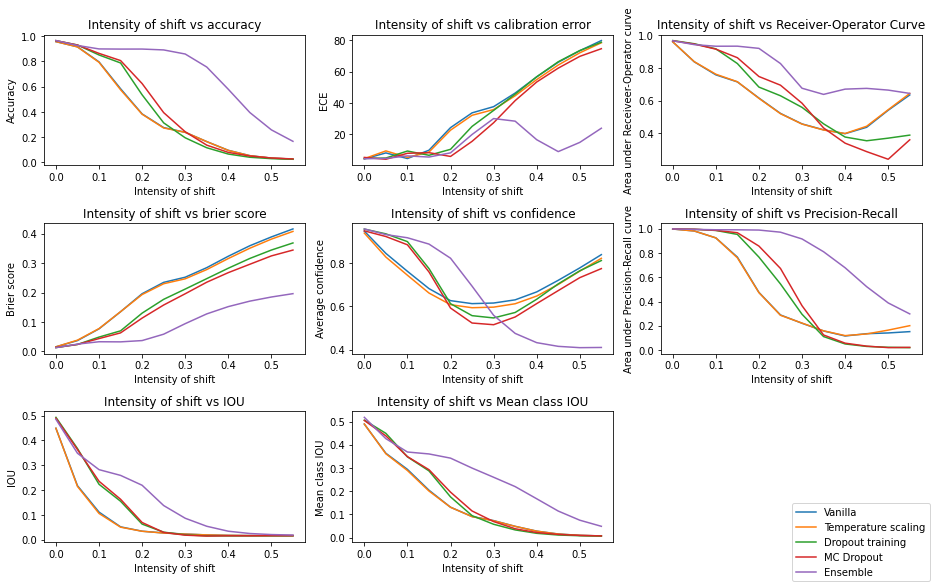

In [24]:
fig, axs = plt.subplots(3, 3, figsize=(13, 8))
for name, m in curves.items():
    ax = axs[0][0]
    ax.plot(m.strengths, m.acc, label=name)
    # ax.legend()
    ax.set_title("Intensity of shift vs accuracy")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Accuracy")

    ax = axs[1][0]
    ax.plot(m.strengths, m.brier, label=name)
    # ax.legend()
    ax.set_title("Intensity of shift vs brier score")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Brier score")

    ax = axs[0][1]
    ax.plot(m.strengths, m.ece, label=name)
    # ax.legend()
    ax.set_title("Intensity of shift vs calibration error")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("ECE")

    ax = axs[1][1]
    ax.plot(m.strengths, m.confs, label=name)
    # ax.legend()
    ax.set_title("Intensity of shift vs confidence")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Average confidence")

    ax = axs[0][2]
    ax.plot(m.strengths, m.auroc, label=name)
    # ax.legend()
    ax.set_title("Intensity of shift vs Receiver-Operator Curve")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Area under Receiveer-Operator curve")

    ax = axs[1][2]
    ax.plot(m.strengths, m.aupr, label=name)
    # ax.legend()
    ax.set_title("Intensity of shift vs Precision-Recall")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Area under Precision-Recall curve")

    ax = axs[2][0]
    ax.plot(m.strengths, m.ious, label=name)
    # ax.legend()
    ax.set_title("Intensity of shift vs IOU")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("IOU")

    ax = axs[2][1]
    ax.plot(m.strengths, m.mious, label=name)
    # ax.legend()
    ax.set_title("Intensity of shift vs Mean class IOU")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Mean class IOU")

    axs[2][2].axis("off")
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')
fig.tight_layout()

plt.savefig("figures/covid19-gaussian-noise.pdf")